In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(ggplot2,  immunarch, randomcoloR, cowplot, factoextra, ggbeeswarm)

# Functions

In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/Immune_diversity.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")

In [4]:
pca_vusage.fx <- function(dta, sampleprocessingdta, sampletype, ell) {
    # subset to PBMC samples
    dta_subset <- repFilter(dta, .method = "by.meta", .query = list(sampletype = include(sampletype)))

    dta_subset$meta <- cbind(dta_subset$meta, sampleprocessingdta[match(
        dta_subset$meta$sample_id,
        sampleprocessingdta$mysample_id
    ), ])
    dta_subset_gu <- as.data.frame(geneUsage(dta_subset$data, "hs.trbv", .norm = T, .quant = "count"))
    rownames(dta_subset_gu) <- dta_subset_gu$Names
    dta_subset_gu$Names <- NULL
    dta_subset_gu[is.na(dta_subset_gu)] <- 0
    res.pca <- prcomp(t(dta_subset_gu), scale. = TRUE, center = TRUE)
    p1 <- fviz_eig(res.pca)
    p2 <- fviz_pca_var(res.pca,
        col.var = "contrib", # Color by contributions to the PC
        gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
        repel = TRUE
    )
    groups <- as.factor(dta_subset$meta$libbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)
    p3 <- fviz_pca_ind(res.pca,
        geom = "point", pointshape = 16, pointsize = 1, alpha = 0.7,
        col.ind = groups,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Library batch"
    ) +
        theme(legend.position = "none") + scale_color_manual(values = myColors)

    groups <- as.factor(dta_subset$meta$capbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)
    p4 <- fviz_pca_ind(res.pca,
        geom = "point", pointshape = 16, pointsize = 1, alpha = 0.7,
        col.ind = groups,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Capture batch"
    ) +
        theme(legend.position = "none") + scale_color_manual(values = myColors)

    return(plot_grid(p1, p2, p3, p4))
}


In [5]:
pca_batch.fx <- function(dta, sampleprocessingdta, sampletype, ell) {
    meta <- repFilter(dta, .method = "by.meta", .query = list(sampletype = include("PBMC")))$meta

    sampleprocessingdta <- sampleprocessingdta[which(sampleprocessingdta$TCR == "Yes"), ]

    meta <- cbind(meta, sampleprocessingdta[match(meta$sample_id, sampleprocessingdta$mysample_id), ])

    meta <- meta[!is.na(meta$TCR), ]

    meta_subset <- meta[, c(
        "TRB", "Reads", "observed_Shannon",
        "q0_v", "q0_j", "DNAextracted", "DNAused", "libraryyield", "captureyield"
    )]

    rownames(meta_subset) <- meta$sample_id

    mypca <- prcomp(meta_subset, scale. = TRUE, center = TRUE)

    p1 <- fviz_eig(mypca)

    p2 <- fviz_pca_var(mypca,
        col.var = "contrib",
        gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), repel = TRUE
    )

    groups <- as.factor(meta$libbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)

    p3 <- fviz_pca_ind(mypca,
        geom = "point", pointshape = 16, pointsize = 1,
        col.ind = groups, alpha = 0.7,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Library batch"
    ) + theme(legend.position = "none") +
        scale_color_manual(values = myColors)

    groups <- as.factor(meta$capbatch)
    myColors <- distinctColorPalette(length(levels(groups)))
    names(myColors) <- levels(groups)

    p4 <- fviz_pca_ind(mypca,
        geom = "point", pointshape = 16, pointsize = 1,
        col.ind = groups, alpha = 0.7,
        addEllipses = ell, ellipse.alpha = 0, invisible = "quali",
        title = "Capture batch"
    ) + theme(legend.position = "none") +
        scale_color_manual(values = myColors)

    return(plot_grid(p1, p2, p3, p4))
}


# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
h4hpath <- "~/Desktop/H4H/INTERCEPT/"

gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

# Main

# PBMC

In [7]:
load(file = paste0(gitpath, "data/pbmc_sampleprocessing.RData"))

In [8]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [9]:
pbmc_samples$sample_id <- NULL

In [10]:
pbmc_samples[ grepl("395", pbmc_samples$Patient),]

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,Successful capture,capturepassed,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
162,n = 321,45800.0,600.0,191104_M04827_0295_000000000-D7FHM,Passed,n = 282,389.76,237.5,191203_M04827_0315_000000000-D7KC5,n = 278,Passed,Yes,n = 278,CHP_395_01,Yes,n = 277,CHP_395,T-ALL,NA
181,n = 321,28.4,28.4,NA,Failed,n = 39,66.72,0.0,NA,NA,,NA,NA,CHP_395_02,No,NA,CHP_395,NA,NA


In [12]:
table(meta_div$sampletype[!is.na(meta_div$TRB)])


cfDNA  PBMC Tumor 
  278   286    17 

In [13]:
all <- merge(pbmc_samples, meta_div[which(meta_div$sampletype == "PBMC"), ], by.x = "mysample_id", by.y = "sample_id")

# divstats_lst_TRB contains all samples with flow data, remove those without tcr data
all <- all[!is.na(all$basename), ]

In [14]:
stats <- read.csv(file = paste0(h4hpath, "NextSeq/logs/align_stats.csv"), header = T)

Warning message in file(file, "rt"):
“cannot open file '/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/logs/align_stats.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [72]:
# 336-04 was mislabeled as 366-04 in the submission form. log and clones file names are corrected on h4h. Fix the sample name in the stats file

stats$Output.file.s.[stats$Output.file.s. == "/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_2_22April2021/mixcr/alignments/alignments_CHP_366-04_PBMC-DNA.vdjca"] <-
    "/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_2_22April2021/mixcr/alignments/alignments_CHP_336-04_PBMC-DNA.vdjca"
stats$Input.file.s.[stats$Output.file.s. == "/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_2_22April2021/mixcr/alignments/alignments_CHP_336-04_PBMC-DNA.vdjca"] <-
    "CHP_336-04_PBMC-DNA_barcode_R1.fastq,CHP_336-04_PBMC-DNA_barcode_R2.fastq"


In [76]:
stats[grepl("366", stats$Output.file.s.),]

,Input.file.s.,Output.file.s.,Version,Total.sequencing.reads,Successfully.aligned.reads,Alignment.failed..no.hits..not.TCR.IG..,Alignment.failed.because.of.absence.of.CDR3.parts,Alignment.failed.because.of.low.total.score,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
67,"CHP_366-FFPE-DNA_S1_barcode_R1.fastq,CHP_366-FFPE-DNA_S1_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batchFFPE_3Apr2020/mixcr/alignments/alignments_CHP_366-FFPE-DNA_S1.vdjca,"2.1.12,repseqio.v1.5",1233836,824693,188448,13771,206924,7263,542957,144958,21276,37547,76266,1689,0,0,0
153,"CHP_366-01-PBMC-DNA_barcode_R1.fastq,CHP_366-01-PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch_reseq_24Feb2020/mixcr/alignments/alignments_CHP_366-01-PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",6902134,4998277,592019,122922,1188916,68472,3457985,895907,153387,274012,216515,281,174,16,0
221,"CHP_366-04_PBMC-DNA_barcode_R1.fastq,CHP_366-04_PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_2_22April2021/mixcr/alignments/alignments_CHP_366-04_PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",46118,44279,490,22,1327,304,2093,101,1,619,41465,0,0,0,0
239,"CHP_366-03_cfDNA_barcode_R1.fastq,CHP_366-03_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/priority_pool3/mixcr/alignments/alignments_CHP_366-03_cfDNA.vdjca,"2.1.12,repseqio.v1.5",5815091,5134964,109053,62520,508554,19562,1930376,177638,72312,199841,2754746,50,0,1,0
272,"CHP_366-02-cfDNA_barcode_R1.fastq,CHP_366-02-cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch1_cfDNA_30Jan2020/mixcr/alignments/alignments_CHP_366-02-cfDNA.vdjca,"2.1.12,repseqio.v1.5",3625940,2663099,219180,55599,688062,8382,1916010,346669,98575,144591,157032,141,67,14,0
274,"CHP_366-01_cfDNA_barcode_R1.fastq,CHP_366-01_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch3a9_cfDNA_10Jul2020/mixcr/alignments/alignments_CHP_366-01_cfDNA.vdjca,"2.1.12,repseqio.v1.5",5500157,4874194,121845,215675,288443,22460,1207714,156687,35878,226759,3247156,0,0,0,0
343,"CHP_366-04_cfDNA_barcode_R1.fastq,CHP_366-04_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch10_cfDNA_13Jul2020/mixcr/alignments/alignments_CHP_366-04_cfDNA.vdjca,"2.1.12,repseqio.v1.5",4436567,3886944,90781,80963,377879,15897,1240456,230134,47242,111830,2257258,24,0,0,0
369,"CHP_366-05_PBMC-DNA_barcode_R1.fastq,CHP_366-05_PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_1_20April2021/mixcr/alignments/alignments_CHP_366-05_PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",8899047,7734104,365866,102144,696933,106648,5599302,744974,167073,1050715,171957,83,0,0,0
377,"CHP_366-05_cfDNA_barcode_R1.fastq,CHP_366-05_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch5_cfDNA_25Jun2020/mixcr/alignments/alignments_CHP_366-05_cfDNA.vdjca,"2.1.12,repseqio.v1.5",4897239,3688593,311046,175938,721662,9657,2176026,592845,106632,183708,629286,96,0,0,0


In [39]:
stats$basename <- gsub("_barcode.*", "",stats$Input.file.s.)

In [40]:
all_stats <- merge(all, stats, by = "basename")

,Input.file.s.,Output.file.s.,Version,Total.sequencing.reads,Successfully.aligned.reads,Alignment.failed..no.hits..not.TCR.IG..,Alignment.failed.because.of.absence.of.CDR3.parts,Alignment.failed.because.of.low.total.score,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
40,"CHP_407-01_cfDNA_barcode_R1.fastq,CHP_407-01_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_3_cfDNA_15April2021/mixcr/alignments/alignments_CHP_407-01_cfDNA.vdjca,"2.1.12,repseqio.v1.5",12013225,10373584,287104,216313,1136224,172244,3582436,527937,131394,322355,5809461,1,0,0,0
236,"CHP_407-04_cfDNA_barcode_R1.fastq,CHP_407-04_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/remaining_batch_3_cfDNA_15April2021/mixcr/alignments/alignments_CHP_407-04_cfDNA.vdjca,"2.1.12,repseqio.v1.5",3605542,3053929,127758,54493,369362,49390,1212930,158528,47961,102280,1532167,63,0,0,0
248,"CHP_407-01_PBMC_DNA_barcode_R1.fastq,CHP_407-01_PBMC_DNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch11_23Apr2020/mixcr/alignments/alignments_CHP_407-01_PBMC_DNA.vdjca,"2.1.12,repseqio.v1.5",2108548,1518470,188117,45431,356530,22014,1009989,264165,50046,83628,110453,134,40,15,0
270,"CHP_407-FFPE-DNA_S7_barcode_R1.fastq,CHP_407-FFPE-DNA_S7_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batchFFPE_3Apr2020/mixcr/alignments/alignments_CHP_407-FFPE-DNA_S7.vdjca,"2.1.12,repseqio.v1.5",8853479,6328990,958463,120067,1445959,49400,4244031,810533,223657,351418,695181,4170,0,0,0
299,"CHP_407-03__PBMC-DN_barcode_R1.fastq,CHP_407-03__PBMC-DN_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch12_30Apr2021/mixcr/alignments/alignments_CHP_407-03__PBMC-DN.vdjca,"2.1.12,repseqio.v1.5",6164876,4723218,406708,157466,877484,69960,3217821,571802,138053,341983,453493,23,37,6,0
312,"CHP_407-02_cfDNA_barcode_R1.fastq,CHP_407-02_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/priority_pool3/mixcr/alignments/alignments_CHP_407-02_cfDNA.vdjca,"2.1.12,repseqio.v1.5",6035387,5106039,245579,125859,557910,23679,1985513,228653,73677,219833,2598066,226,71,0,0
356,"CHP_407-04-PBMC-DNA_barcode_R1.fastq,CHP_407-04-PBMC-DNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch13_26Aug2020/mixcr/alignments/alignments_CHP_407-04-PBMC-DNA.vdjca,"2.1.12,repseqio.v1.5",3321851,2880916,107515,88581,244839,71399,1056767,237815,43981,299846,1242402,79,26,0,0
435,"CHP_407-03_cfDNA_barcode_R1.fastq,CHP_407-03_cfDNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch11_cfDNA_11Sep2020/mixcr/alignments/alignments_CHP_407-03_cfDNA.vdjca,"2.1.12,repseqio.v1.5",6927443,6022903,157915,83824,662801,75786,2213725,288698,87448,176513,3256518,0,0,1,0
460,"CHP_407-02_PBMC_DNA_barcode_R1.fastq,CHP_407-02_PBMC_DNA_barcode_R2.fastq",/cluster/projects/pughlab/projects/INTERCEPT/NextSeq/batch11_23Apr2020/mixcr/alignments/alignments_CHP_407-02_PBMC_DNA.vdjca,"2.1.12,repseqio.v1.5",2976358,2148970,256896,80061,490431,29796,1497920,257893,76843,141137,175039,76,55,7,0


In [42]:
dim(all)

[1] 274  83

In [43]:
tmp <- (meta_div[!is.na(meta_div$TRB),])
tmp <- tmp[ tmp$sampletype == "PBMC",]

In [44]:
dim(tmp)

[1] 284  65

In [45]:
(tmp$sample_id[ !tmp$sample_id %in% all_stats$mysample_id])

[1] "CHP_336_04"      "LFS_TCR_4535_00" "LFS_TCR_4570_00" "LFS_TCR_4602_00"
 [5] "LFS_TCR_4758_00" "LFS_TCR_4759_00" "LFS_TCR_4783_00" "LFS_TCR_4837_00"
 [9] "LFS_TCR_4838_00" "LFS_TCR_5014_00" "LFS_TCR_5067_00"

In [46]:
all_stats[ grepl("336", all_stats$basename),]

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
20,CHP_336-05_PBMC-DNA,CHP_336_05,n = 321,309.946,24.6,191210_M04827_0319_000000000-D7M28,Passed,n = 282,1276.8,551,...,550542,7788106,968850,162688,3104926,10221917,2166,907,218,0


In [47]:
head(all_stats)

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,Alignment.aided.overlaps,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,n = 321,4120,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1449.6,13.338,...,89607,2500371,369721,74186,428666,1713555,0,563,0,0
2,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,n = 321,4880,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1948.8,6.232,...,154030,3481524,550846,116455,489440,2318341,0,0,0,0
3,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,n = 321,18200,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1545.6,7.942,...,123671,3488717,549330,157638,486162,1686316,1052,0,0,0
4,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,n = 321,35400,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1171.2,7.942,...,178259,5292852,875254,241875,663487,2991528,793,309,0,0
5,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,n = 321,7920,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1843.2,6.232,...,189814,4275428,660748,130568,632122,2711248,0,1072,0,0
6,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,n = 321,3460,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,2227.2,4.294,...,117485,3382456,472114,117300,452204,2111692,0,0,0,0


In [25]:
dim(all_stats) # minus 10 LFS

[1] 272 101

In [26]:
all_stats$percaligned <- all_stats$Successfully.aligned.reads / all_stats$Total.sequencing.reads


In [27]:
all_stats[ grepl("324", all_stats$basename),]

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
14,CHP_324-05_PBMC-DNA,CHP_324_05,n = 321,400,107.6,191210_M04827_0319_000000000-D7M28,Passed,n = 282,1372.8,744.8,...,2017528,210124,45860,625207,3567562,328,148,16,0,0.8251416


In [28]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6187  0.7307  0.7611  0.7804  0.8408  0.9781 

In [29]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   95776  2978500  5208360  5821431  6835648 78168018 

In [30]:
summary(all_stats$Successfully.aligned.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   71989  2274299  4089644  4589625  5381270 59997822 

In [31]:
p1 <- histdenp(all_stats, "Total.sequencing.reads/1000000", 1)
p2 <- histdenp(all_stats, "Successfully.aligned.reads/1000000", 1)
p3 <- histdenp(all_stats, "percaligned", 0.01)


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [32]:
p4 <- histdenp(all_stats, "TRB", 20)
p5 <- histdenp(all_stats, "Reads/100", 100)


In [33]:
p00 <- histdenp(all_stats, "DNAused", 30)

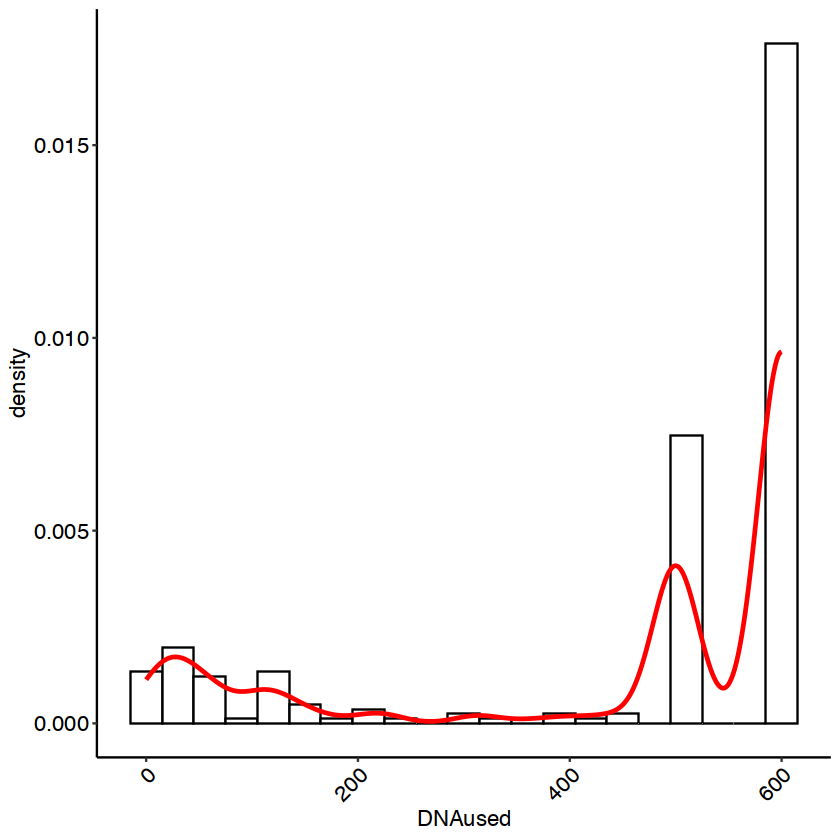

In [34]:
p00

In [35]:
p6 <- ggplot(data = all_stats, aes(x = DNAused, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p7 <- ggplot(data = all_stats, aes(x = libraryyield, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p8 <- ggplot(data = all_stats, aes(x = captureyield, y = TRB)) +
    geom_point() +
    myplot +
    myaxis


In [36]:
p9 <- ggplot(data = all_stats, aes(x = Total.sequencing.reads / 1000000, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p10 <- ggplot(data = all_stats, aes(x = Successfully.aligned.reads / 1000000, y = TRB)) +
    geom_point() +
    myplot +
    myaxis
p11 <- ggplot(data = all_stats, aes(x = percaligned, y = TRB)) +
    geom_point() +
    myplot +
    myaxis


In [37]:
p12 <- ggplot(data = all_stats, aes(x = capbatch, y = TRB)) +
    geom_boxplot() +
    geom_beeswarm(cex = 0.1) +
    myplot +
    myaxis +
    theme(axis.text.x = element_blank())
p13 <- ggplot(data = all_stats, aes(x = libbatch, y = TRB)) +
    geom_boxplot() +
    geom_beeswarm(cex = 0.5) +
    myplot +
    myaxis +
    theme(axis.text.x = element_blank())


In [38]:
pdf(paste0(plotpath, "QC_PBMC.pdf"),
    width = 30, height = 30
)
plot_grid(p1, p2, p3, p4, p5,
    p6, p7, p8, p9, p10,
    p11, p12, p13,
    ncol = 3
)
dev.off()


pdf 
  2

In [39]:
head(all_stats)

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,n = 321,4120,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1449.6,13.338,...,2500371,369721,74186,428666,1713555,0,563,0,0,0.7415962
2,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,n = 321,4880,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1948.8,6.232,...,3481524,550846,116455,489440,2318341,0,0,0,0,0.7540386
3,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,n = 321,18200,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1545.6,7.942,...,3488717,549330,157638,486162,1686316,1052,0,0,0,0.7519197
4,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,n = 321,35400,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1171.2,7.942,...,5292852,875254,241875,663487,2991528,793,309,0,0,0.7668919
5,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,n = 321,7920,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1843.2,6.232,...,4275428,660748,130568,632122,2711248,0,1072,0,0,0.7560349
6,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,n = 321,3460,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,2227.2,4.294,...,3382456,472114,117300,452204,2111692,0,0,0,0,0.7574009


In [40]:
summary(all_stats$Total.sequencing.reads)
summary(all_stats$Successfully.aligned.reads)
summary(all_stats$libraryyield)
summary(all_stats$captureyield)
summary(all_stats$percaligned)
summary(all_stats$TRB)
summary(all_stats$Reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   95776  2978500  5208360  5821431  6835648 78168018 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   71989  2274299  4089644  4589625  5381270 59997822 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   12.0   451.7   751.2   994.5  1238.4  8112.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   4.294   74.860  158.270  284.182  337.725 1311.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6187  0.7307  0.7611  0.7804  0.8408  0.9781 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    45.0   125.5   243.3   351.0  2237.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     10    1103    3316   32559   32723  363060 

## PCA V usage

In [41]:
load(file = paste0(datapath, "capTCRseq/int_load_meta.RData"))

In [42]:
pbmc_pca <- pca_vusage.fx(int_load, pbmc_samples, "PBMC", "FALSE")

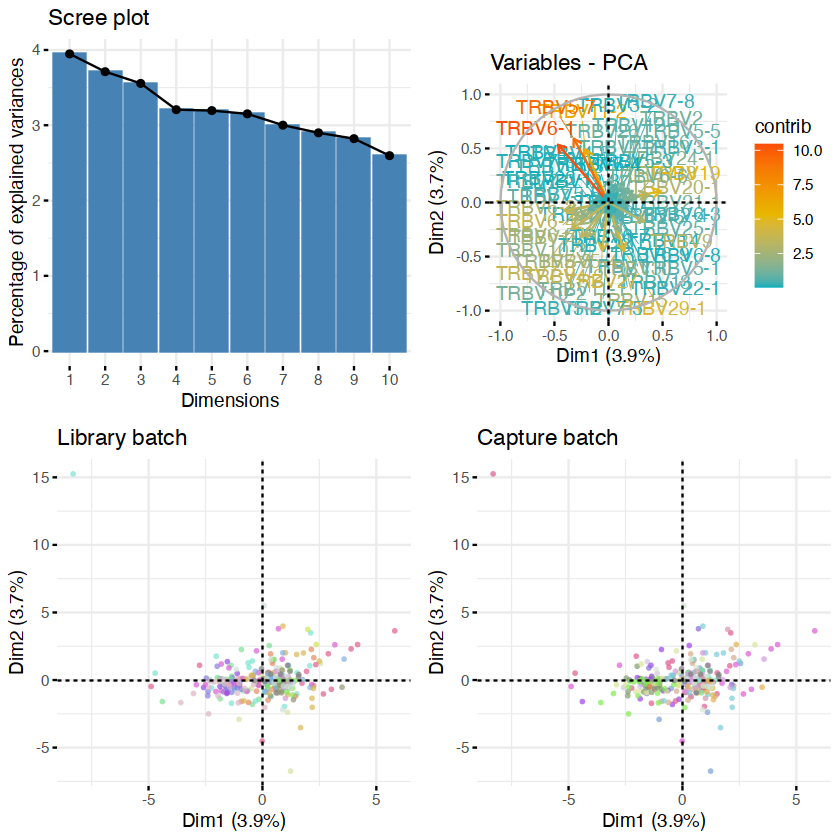

In [43]:
pbmc_pca

In [44]:
pdf(paste0(plotpath, "PBMC_Vusage_PCA.pdf"),
    width = 10, height = 10
)
pbmc_pca
dev.off()


pdf 
  2

## PCA experimental measures

In [45]:
pca_batch <- pca_batch.fx(int_load, pbmc_samples, "PBMC", "FALSE")

ERROR: Error in prcomp.default(meta_subset, scale. = TRUE, center = TRUE): cannot rescale a constant/zero column to unit variance


In [47]:
    meta <- repFilter(int_load, .method = "by.meta", .query = list(sampletype = include("PBMC")))$meta


In [48]:
    sampleprocessingdta <- pbmc_samples[which(pbmc_samples$TCR == "Yes"), ]


In [54]:
table(pbmc_samples$TCR)


 No 
321 

In [53]:
head(pbmc_samples[which(pbmc_samples$TCR == "Yes"), ])

Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>


In [49]:
    meta <- cbind(meta, sampleprocessingdta[match(meta$sample_id, sampleprocessingdta$mysample_id), ])


In [50]:
head(meta)

,Sample,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,...,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
NA,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,CHP_10YO_M,X00,NA,NA,NA,Normal,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,CHP_11YO_M,X00,NA,NA,NA,Normal,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,CHP_15YO_F_A,X00,NA,NA,NA,Normal,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,CHP_15YO_F_B,X00,NA,NA,NA,Normal,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.4,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,CHP_15YO_M,X00,NA,NA,NA,Normal,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.5,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,CHP_16YO_M,X00,NA,NA,NA,Normal,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [ ]:

    sampleprocessingdta <- sampleprocessingdta[which(sampleprocessingdta$TCR == "Yes"), ]

    meta <- cbind(meta, sampleprocessingdta[match(meta$sample_id, sampleprocessingdta$mysample_id), ])

    meta <- meta[!is.na(meta$TCR), ]

    meta_subset <- meta[, c(
        "TRB", "Reads", "observed_Shannon",
        "q0_v", "q0_j", "DNAextracted", "DNAused", "libraryyield", "captureyield"
    )]

    rownames(meta_subset) <- meta$sample_id

    mypca <- prcomp(meta_subset, scale. = TRUE, center = TRUE)

In [46]:
pca_batch

ERROR: Error in eval(expr, envir, enclos): object 'pca_batch' not found


In [ ]:
pdf(paste0(plotpath, "PBMC_batch_PCA.pdf"),
    width = 10, height = 10)
pca_batch
dev.off()

pdf 
  2

## Remove samples

In [30]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   95776  2978500  5208360  5821431  6835648 78168018 

In [31]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6187  0.7307  0.7611  0.7804  0.8408  0.9781 

In [32]:
dim(all_stats)

[1] 272 102

In [33]:
all_stats[ grepl("372", all_stats$mysample_id), "Total.sequencing.reads"]

[1] 8991539

In [46]:
head(pbmc_samples,3)

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,n = 321,6160,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,825.6,155.42,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_330_05,No,n = 278,CHP_330,NA,NA
2,n = 321,11200,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,2006.4,155.42,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_329_04,No,n = 278,CHP_329,NA,NA
3,n = 321,3780,600,190517_M04827_0203_000000000-D6BYT,Passed,n = 282,1161.6,162.64,190624_M04827_0214_000000000-D6F66,Passed,n = 278,Yes,n = 278,CHP_331_05,No,n = 278,CHP_331,NA,NA


In [44]:
dim(all_stats)

[1] 272 102

In [45]:
head(all_stats)

,basename,mysample_id,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,n = 321,4120,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1449.6,13.338,...,2500371,369721,74186,428666,1713555,0,563,0,0,0.7415962
2,CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,n = 321,4880,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1948.8,6.232,...,3481524,550846,116455,489440,2318341,0,0,0,0,0.7540386
3,CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,n = 321,18200,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1545.6,7.942,...,3488717,549330,157638,486162,1686316,1052,0,0,0,0.7519197
4,CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,n = 321,35400,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1171.2,7.942,...,5292852,875254,241875,663487,2991528,793,309,0,0,0.7668919
5,CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,n = 321,7920,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,1843.2,6.232,...,4275428,660748,130568,632122,2711248,0,1072,0,0,0.7560349
6,CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,n = 321,3460,600,191220_M04827_0327_000000000-D7W4D,Passed,n = 282,2227.2,4.294,...,3382456,472114,117300,452204,2111692,0,0,0,0,0.7574009


In [48]:
pbmc_samples[!pbmc_samples$mysample_id %in% all_stats$mysample_id,]

,Shipped,DNAextracted,DNAused,libbatch,librarypassed,Library preparation,libraryyield,captureyield,capbatch,capturepassed,Successful capture,deepseq,Deep sequencing,mysample_id,TCR,TCR analysis,Patient,Tumor,Group
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
34,n = 321,26000.00,600.00,190521_M04827_0204_000000000-D6BKL,Passed,n = 282,3705.600,21.280,190531_M00753_0126_000000000-D6D7Y,Passed,n = 278,Yes,n = 278,CHP_356_04,No,n = 278,CHP_356,NA,NA
49,n = 321,11200.00,600.00,190607_M04827_0206_000000000-D6C75,Passed,n = 282,537.600,84.360,D6WFR,Passed,n = 278,Yes,n = 278,CHP_315_05,No,n = 278,CHP_315,NA,NA
58,n = 321,3820.00,600.00,190607_M04827_0206_000000000-D6C75,Passed,n = 282,2697.600,78.660,D6WFR,Passed,n = 278,Yes,n = 278,CHP_303_05,No,n = 278,CHP_303,NA,NA
83,n = 321,665.00,600.00,190916_M04827_0264_000000000-D74G2,Passed,n = 282,196.800,5.852,NA,Failed,n = 4,NA,NA,CHP_341_05,No,NA,CHP_341,NA,NA
91,n = 321,695.00,600.00,190916_M04827_0264_000000000-D74G2,Passed,n = 282,600.000,7.334,NA,Failed,n = 4,NA,NA,CHP_351_05,No,NA,CHP_351,NA,NA
93,n = 321,245.05,38.30,191210_M04827_0319_000000000-D7M28,Passed,n = 282,552.000,410.400,201216_M04827_0481_000000000-D9VL2,Passed,n = 278,Yes,n = 278,CHP_336_04,No,n = 278,CHP_336,NA,NA
103,n = 321,745.00,600.00,190916_M04827_0264_000000000-D74G2,Passed,n = 282,950.400,21.090,NA,Failed,n = 4,NA,NA,CHP_339_04,No,NA,CHP_339,NA,NA
161,n = 321,35600.00,600.00,191104_M04827_0295_000000000-D7FHM,Passed,n = 282,662.400,237.500,191203_M04827_0315_000000000-D7KC5,Passed,n = 278,Yes,n = 278,CHP_381_04,No,n = 278,CHP_381,NA,NA
162,n = 321,45800.00,600.00,191104_M04827_0295_000000000-D7FHM,Passed,n = 282,389.760,237.500,191203_M04827_0315_000000000-D7KC5,Passed,n = 278,Yes,n = 278,CHP_395_01,No,n = 278,CHP_395,NA,NA


In [43]:
table(pbmc_samples$`TCR analysis`,useNA = "always")


n = 278    <NA> 
    278      43 

In [40]:
# remove 22 samples with < 2mil reads
subset_pbmc <- all_stats[all_stats$Total.sequencing.reads > 2000000,]

In [41]:
dim(subset_pbmc)

[1] 249 102

In [47]:
summary(subset_pbmc$DNAused)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   430.0   600.0   448.5   600.0   600.0 

In [48]:
# one sample is 0 ng added in error in lab processing excel file
## remove 38 samples with < 100 ng input DNA

subset_pbmc <- subset_pbmc[ subset_pbmc$DNAused >= 100,]

In [49]:
dim(subset_pbmc)

[1] 211 100

In [50]:
save(subset_pbmc, file = paste0(datapath, "capTCRseq/PBMC_GoodSamples.RData"))

In [51]:
dim(all)
dim(all_stats)

[1] 272  81

[1] 272 100

# cfDNA

In [52]:
load(file = paste0(gitpath, "data/cfdna_sampleprocessing.RData"))

In [53]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [54]:
cfdna_samples$sample_id <- NULL

In [55]:
all <- merge(cfdna_samples, meta_div[ which(meta_div$sampletype == "cfDNA"),], by.x = "mysample_id", by.y = "sample_id")

# divstats_lst_TRB contains all samples with flow data, remove those without tcr data
all <- all[!is.na(all$basename),]

In [56]:
dim(all)

[1] 286  82

In [57]:
stats <- read.csv(file = paste0(datapath, "capTCRseq/align_stats.csv"), header = T)

In [58]:
stats$basename <- gsub("_barcode.*", "",stats$Input.file.s.)

In [59]:
all_stats <- merge(all, stats, by = "basename")

In [60]:
dim(all)

[1] 286  82

In [61]:
dim(all_stats)

[1] 286 100

In [62]:
all_stats$percaligned <- all_stats$Successfully.aligned.reads/all_stats$Total.sequencing.reads

In [63]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6693  0.8203  0.8660  0.8380  0.8806  0.9278 

In [64]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22839  3909173  4880550  5747415  6625276 18558893 

In [65]:
summary(all_stats$Successfully.aligned.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   20740  3148315  4193616  4877297  5820301 16382810 

In [66]:
p1 <- histdenp(all_stats, "Total.sequencing.reads/1000000", 1)
p2 <- histdenp(all_stats, "Successfully.aligned.reads/1000000", 1)
p3 <- histdenp(all_stats, "percaligned", 0.01)

In [67]:
p4 <- histdenp(all_stats, "TRB", 5)
p5 <- histdenp(all_stats, "Reads/100", 5)

In [68]:
p6 <- ggplot(data = all_stats, aes( x = DNAused, y = TRB)) + geom_point() + myplot + myaxis
p7 <- ggplot(data = all_stats, aes( x = libraryyield, y = TRB)) + geom_point() + myplot + myaxis
p8 <- ggplot(data = all_stats, aes( x = captureyield, y = TRB)) + geom_point() + myplot + myaxis

In [69]:
p9 <- ggplot(data = all_stats, aes( x = Total.sequencing.reads/1000000, y = TRB)) + geom_point() + myplot + myaxis
p10 <- ggplot(data = all_stats, aes( x = Successfully.aligned.reads/1000000, y = TRB)) + geom_point() + myplot + myaxis
p11 <- ggplot(data = all_stats, aes( x = percaligned, y = TRB)) + geom_point() + myplot + myaxis

In [70]:
p12 <- ggplot(data = all_stats, aes( x = capbatch, y = TRB)) + geom_boxplot() +geom_beeswarm(cex = 0.1)+ myplot + myaxis +
theme( axis.text.x = element_blank())
p13 <- ggplot(data = all_stats, aes( x = libbatch, y = TRB)) + geom_boxplot() +geom_beeswarm(cex = 0.5) + myplot + myaxis +
theme( axis.text.x = element_blank())

In [71]:
pdf(paste0(plotpath, "QC_cfDNA.pdf"),
    width = 30, height = 30)
plot_grid(p1,p2, p3, p4, p5, p6,p7,p8,p9,p10, p11,p12,p13, ncol = 3)
dev.off()

Warning message:
“Removed 8 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_density()`).”


Warning message:
“Removed 8 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


pdf 
  2

In [72]:
summary(all_stats$Total.sequencing.reads)
summary(all_stats$Successfully.aligned.reads)
summary(all_stats$libraryyield)
summary(all_stats$captureyield)
summary(all_stats$percaligned)
summary(all_stats$TRB)
summary(all_stats$Reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22839  3909173  4880550  5747415  6625276 18558893 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   20740  3148315  4193616  4877297  5820301 16382810 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.82  200.88  324.48  349.22  456.24 1017.60 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  104.5   342.0   585.2   628.4   855.0  1641.6       1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6693  0.8203  0.8660  0.8380  0.8806  0.9278 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    3.00    7.00   13.98   16.00  220.00       8 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      1     354    2964    6537    7882   88874       8 

## PCA V usage

In [ ]:
load(file = paste0(gitpath, "data/cfdna_sampleprocessing.RData"))

In [ ]:
load(file = paste0(datapath, "capTCRseq/int_load_meta.RData"))

Warning message in load(file = paste0(datapath, "capTCRseq/int_load_meta.RData")):
"strings not representable in native encoding will be translated to UTF-8"


In [ ]:
cfdna_pca <- pca_vusage.fx(int_load, cfdna_samples, "cfDNA", "FALSE")

Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.TE' to native encoding"


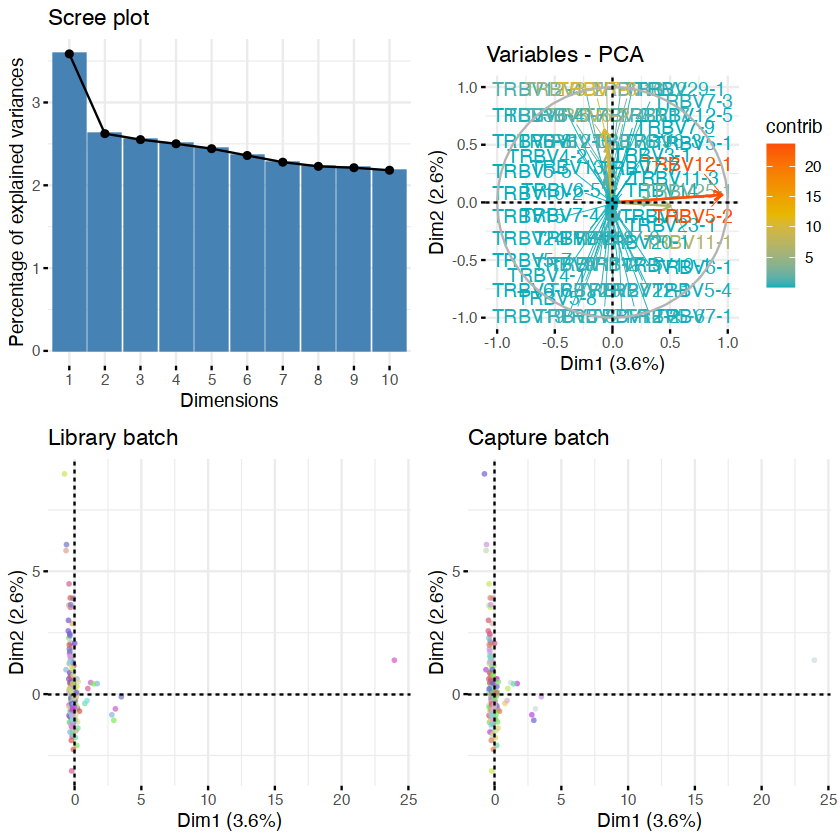

In [ ]:
cfdna_pca

In [ ]:
pdf(paste0(plotpath, "cfDNA_Vusage_PCA.pdf"),
    width = 10, height = 10)
cfdna_pca
dev.off()

pdf 
  2

In [ ]:
head(int_load$meta)

Sample,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,...,q0_aa,q0_v,q0_j,q0_aav,q0_vj,q1_aa,q1_v,q1_j,q1_aav,q1_vj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_10YO-M_PBMC_DNA,CHP_10YO_M_00,CHP_10YO_M,X00,NA,NA,NA,Normal,NA,NA,...,22,16,8,22,12.0,12.787814,9.563643,5.074581,12.787814,7.319112
CHP_11YO-M_PBMC_DNA,CHP_11YO_M_00,CHP_11YO_M,X00,NA,NA,NA,Normal,NA,NA,...,21,15,11,21,13.0,14.411620,11.695680,8.890122,14.411620,10.292901
CHP_15YO-F-A_PBMC_DNA,CHP_15YO_F_A_00,CHP_15YO_F_A,X00,NA,NA,NA,Normal,NA,NA,...,13,12,8,13,10.0,10.930258,9.683620,6.059679,10.930258,7.871649
CHP_15YO-F-B_PBMC_DNA,CHP_15YO_F_B_00,CHP_15YO_F_B,X00,NA,NA,NA,Normal,NA,NA,...,9,8,7,9,7.5,8.294830,6.692670,6.084720,8.294830,6.388695
CHP_15YO-M_PBMC_DNA,CHP_15YO_M_00,CHP_15YO_M,X00,NA,NA,NA,Normal,NA,NA,...,33,22,10,33,16.0,29.070103,20.127211,7.641330,29.070103,13.884271
CHP_16YO-M_PBMC_DNA,CHP_16YO_M_00,CHP_16YO_M,X00,NA,NA,NA,Normal,NA,NA,...,7,6,6,7,6.0,5.495512,5.434412,4.355165,5.495512,4.894789


In [ ]:
temp <- repFilter(int_load, .method = "by.meta", .query = list(Sample = exclude("CHP_374-05-cfDNA")))

Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.TE' to native encoding"


In [ ]:
cfdna_pca <- pca_vusage.fx(temp, cfdna_samples, "cfDNA", "FALSE")

Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.TE' to native encoding"


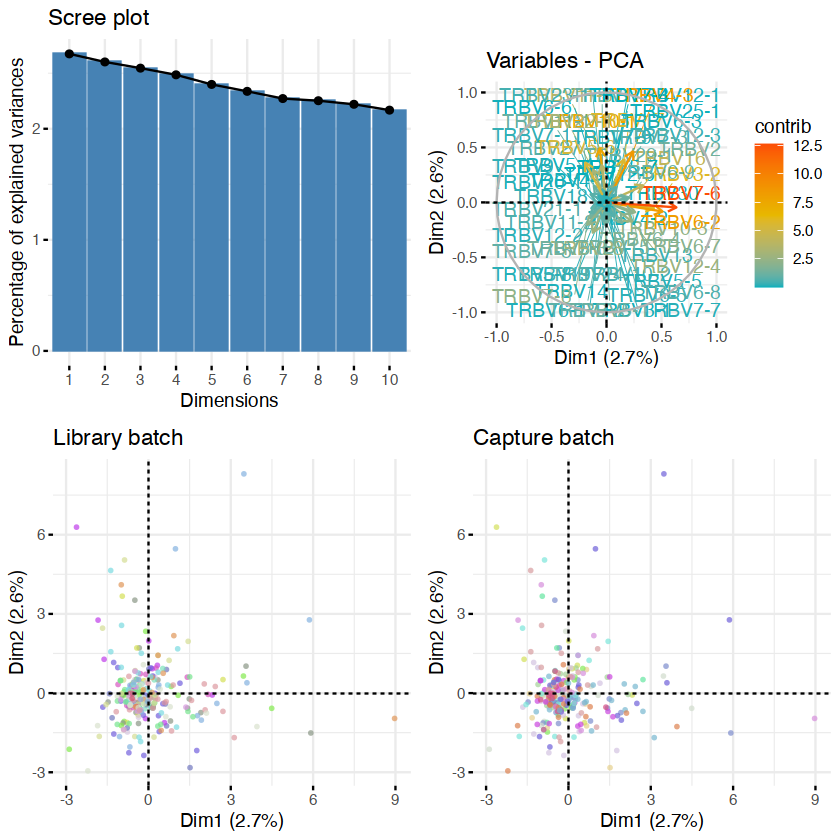

In [ ]:
cfdna_pca

## PCA experimental measures

In [ ]:
pca_batch <- pca_batch.fx(int_load, cfdna_samples, "cfDNA", "FALSE")

Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.' to native encoding"
Warning message in eval(e, x, parent.frame()):
"unable to translate 'Na<U+00EF>ve.TE' to native encoding"


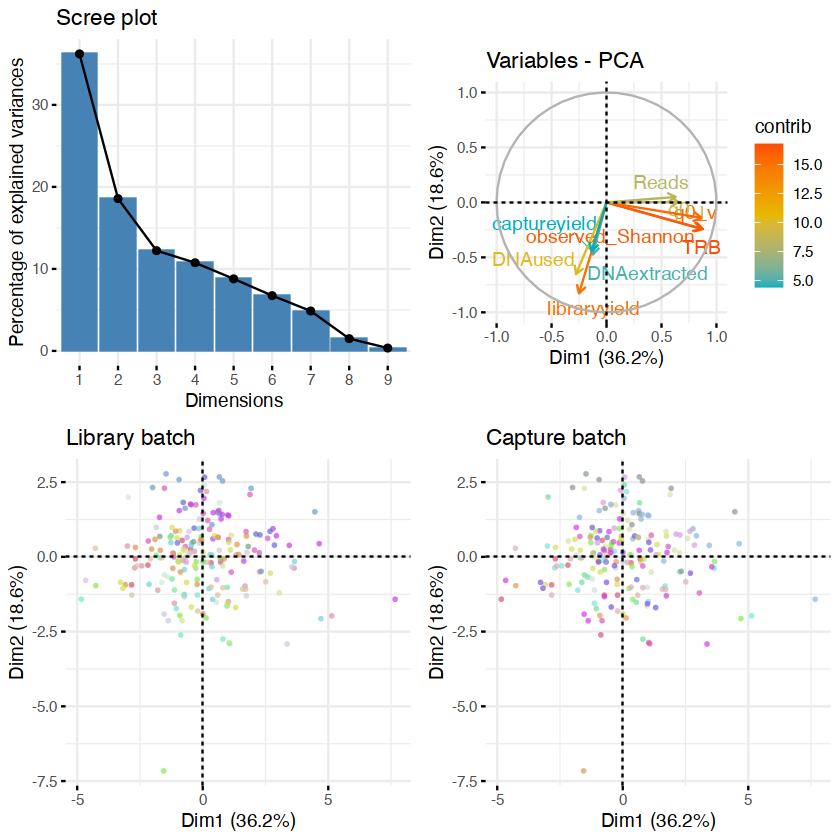

In [ ]:
pca_batch

In [ ]:
pdf(paste0(plotpath, "cfDNA_batch_PCA.pdf"),
    width = 10, height = 10)
pca_batch
dev.off()

pdf 
  2

## Remove samples

In [73]:
summary(all_stats$Total.sequencing.reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22839  3909173  4880550  5747415  6625276 18558893 

In [74]:
summary(all_stats$percaligned)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6693  0.8203  0.8660  0.8380  0.8806  0.9278 

In [75]:
# remove 7 samples with < 2mil reads
subset_cfdna <- all_stats[all_stats$Total.sequencing.reads > 2000000,]

In [76]:
dim(subset_cfdna)

[1] 279 101

In [77]:
# remove the outlier from V usage, CHP_374-05-cfDNA It is an EWS case with one TRB and 3 reads.

In [78]:
subset_cfdna <- subset_cfdna[!grepl("CHP_374-05-cfDNA", subset_cfdna$basename),]

In [79]:
dim(subset_cfdna)

[1] 278 101

In [80]:
colnames(subset_cfdna)

[1] "basename"                                         
  [2] "mysample_id"                                      
  [3] "DNA samples"                                      
  [4] "DNAextracted"                                     
  [5] "DNAused"                                          
  [6] "librarypassed"                                    
  [7] "libbatch"                                         
  [8] "Library preparation"                              
  [9] "libraryyield"                                     
 [10] "DNAforcapture"                                    
 [11] "captureyield"                                     
 [12] "capbatch"                                         
 [13] "capturepassed"                                    
 [14] "Successful capture"                               
 [15] "deepseq"                                          
 [16] "Deep sequencing"                                  
 [17] "TCR"                                              
 [18] "TCR analysis"                                     
 [19] "Patient.x"                                        
 [20] "Tumor"                                            
 [21] "Group.x"                                          
 [22] "Patient.y"                                        
 [23] "cycle"                                            
 [24] "FOLD"                                             
 [25] "ATC"                                              
 [26] "Age"                                              
 [27] "Disease_type"                                     
 [28] "TE_fold"                                          
 [29] "CD3"                                              
 [30] "EM"                                               
 [31] "CM"                                               
 [32] "Naïve"                                            
 [33] "SCM"                                              
 [34] "TE"                                               
 [35] "EM%"                                              
 [36] "CM%"                                              
 [37] "Naïve%"                                           
 [38] "SCM%"                                             
 [39] "TE%"                                              
 [40] "Naïve/TE"                                         
 [41] "N+CM+SCM/TE+EM"                                   
 [42] "PD-1"                                             
 [43] "PDL1"                                             
 [44] "LAG3"                                             
 [45] "TIM3"                                             
 [46] "CTLA4"                                            
 [47] "PD1%"                                             
 [48] "PDL1%"                                            
 [49] "LAG3%"                                            
 [50] "TIM3%"                                            
 [51] "CTLA4%"                                           
 [52] "Any NCR"                                          
 [53] "PD1 + LAG3 + TIM3"                                
 [54] "cancergroup"                                      
 [55] "agegroup"                                         
 [56] "foldgroup"                                        
 [57] "Remission"                                        
 [58] "Relapse"                                          
 [59] "Transplant"                                       
 [60] "CART"                                             
 [61] "TRB"                                              
 [62] "Reads"                                            
 [63] "CPKR"                                             
 [64] "Average_reads"                                    
 [65] "VMR"                                              
 [66] "Max_reads"                                        
 [67] "Singletons"                                       
 [68] "Doubletons"                                       
 [69] "qD"                                               


In [81]:
summary(subset_cfdna$DNAused)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.002  14.362  20.000  17.186  20.000  20.000 

In [82]:
subset_cfdna[ subset_cfdna$DNAused < 5, ]

,basename,mysample_id,DNA samples,DNAextracted,DNAused,librarypassed,libbatch,Library preparation,libraryyield,DNAforcapture,...,TRA.chains,TRB.chains,TRD.chains,TRG.chains,TRA.TRD.chains,IGH.chains,IGK.chains,IGL.chains,chains,percaligned
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
103,CHP_365-05_cfDNA,CHP_365_05,n = 316,0.6,4.956,Passed,200604_M04827_0388_000000000-D8756,n = 316,73.44,73.44,...,1184597,130589,32676,185880,1580458,0,0,0,0,0.8895689
143,CHP_378-03_cfDNA,CHP_378_03,n = 316,0.4,4.928,Passed,200604_M04827_0388_000000000-D8756,n = 316,128.64,128.64,...,2101815,242297,80375,168265,2795981,120,0,0,0,0.8684310
193,CHP_391-04_cfDNA,CHP_391_04,n = 316,0.4,3.002,Passed,200604_M04827_0388_000000000-D8756,n = 316,84.96,84.96,...,1996636,236779,72417,220362,3116877,0,0,0,0,0.8882489
281,CHP_419-01_cfDNA,CHP_419_01,n = 316,0.4,4.730,Passed,200604_M04827_0388_000000000-D8756,n = 316,121.92,121.92,...,2790707,290355,89882,367018,4388924,0,163,0,0,0.8799967


In [83]:
subset_cfdna <- subset_cfdna[ subset_cfdna$DNAused >= 5, ]

In [84]:
dim(subset_cfdna)

[1] 274 101

In [85]:
save(subset_cfdna, file = paste0(datapath, "capTCRseq/cfDNA_GoodSamples.RData"))